<a href="https://colab.research.google.com/github/ostrichkim/colab/blob/main/assignment_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy folder
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models /content/
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py /content/

'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models' -> '/content/models'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/resnet.py' -> '/content/models/resnet.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/dla_simple.py' -> '/content/models/dla_simple.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/MobileNetV2.py' -> '/content/models/MobileNetV2.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/__init__.py' -> '/content/models/__init__.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py' -> '/content/utils.py'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import random

from models import *

random.seed(1)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
img_size=112
# img_size=224
learning_rate = 0.0001
epochs = 30
weight_decay = 5e-4
momentum = 0.9
batch_size = 16
num_workers = 2
num_classes = 20

In [6]:
# Normalize with mean and std
from torchvision.io import read_image
from torchvision import datasets

# trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data',
#                  transform=transforms.ToTensor())
trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200',
                 transform=transforms.ToTensor())
testset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data',
                 transform=transforms.ToTensor())

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

train_mean, train_std = get_mean_and_std(trainset)
test_mean, test_std = get_mean_and_std(testset)
print(train_mean, train_std, '\n', test_mean, test_std)

==> Computing mean and std..


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


==> Computing mean and std..
tensor([0.5994, 0.5260, 0.4337]) tensor([0.2356, 0.2540, 0.2774]) 
 tensor([0.6083, 0.5351, 0.4456]) tensor([0.2308, 0.2525, 0.2799])


In [7]:
# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.ColorJitter(brightness=(0.2, 3)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    transforms.Normalize(train_mean, train_std), # Customized mean and std
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    transforms.Normalize(test_mean, test_std), # Customized mean and std
])

# trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data', transform=transform_train)
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

==> Preparing data..


In [8]:
# Model
print('==> Building model..')
#net = MobileNetV2(num_classes)
net = ResNet50(num_classes)
#net = SimpleDLA(num_classes=num_classes)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [9]:
# Adjust below codes if you want to train model continuously.
if False: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)

In [11]:
# Training
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1)%25==0:
            print("epoch : {}, Train iter : {} / {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
                epoch, 
                batch_idx+1, len(trainloader), 
                train_loss/(batch_idx+1), 
                100.*correct/total, correct, total))

    print("Train epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch, 
        train_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*correct/total)

# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(epoch))
        best_acc = acc

    print("Test epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch,
        test_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*correct/total)

In [12]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

epoch : 0, Train iter : 25 / 250, Loss : 3.1283, Acc : 6.75% | 27 / 400
epoch : 0, Train iter : 50 / 250, Loss : 3.0427, Acc : 9.12% | 73 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 0, Train iter : 75 / 250, Loss : 2.9676, Acc : 10.67% | 128 / 1200
epoch : 0, Train iter : 100 / 250, Loss : 2.9185, Acc : 11.31% | 181 / 1600
epoch : 0, Train iter : 125 / 250, Loss : 2.8836, Acc : 12.15% | 243 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 0, Train iter : 150 / 250, Loss : 2.8502, Acc : 12.58% | 302 / 2400
epoch : 0, Train iter : 175 / 250, Loss : 2.8101, Acc : 13.00% | 364 / 2800
epoch : 0, Train iter : 200 / 250, Loss : 2.7760, Acc : 14.16% | 453 / 3200
epoch : 0, Train iter : 225 / 250, Loss : 2.7521, Acc : 15.03% | 541 / 3600
epoch : 0, Train iter : 250 / 250, Loss : 2.7472, Acc : 15.07% | 603 / 4000
Train epoch : 0, Loss : 2.7472, Acc : 15.07% | 603 / 4000
Saving..
Test epoch : 0, Loss : 2.4338, Acc : 23.75% | 95 / 400
epoch : 1, Train iter : 25 / 250, Loss : 2.4617, Acc : 20.75% | 83 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 50 / 250, Loss : 2.5239, Acc : 19.12% | 153 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 75 / 250, Loss : 2.5199, Acc : 19.25% | 231 / 1200
epoch : 1, Train iter : 100 / 250, Loss : 2.5238, Acc : 19.19% | 307 / 1600
epoch : 1, Train iter : 125 / 250, Loss : 2.5030, Acc : 20.00% | 400 / 2000
epoch : 1, Train iter : 150 / 250, Loss : 2.5046, Acc : 20.54% | 493 / 2400
epoch : 1, Train iter : 175 / 250, Loss : 2.5104, Acc : 20.18% | 565 / 2800
epoch : 1, Train iter : 200 / 250, Loss : 2.5013, Acc : 20.62% | 660 / 3200
epoch : 1, Train iter : 225 / 250, Loss : 2.4888, Acc : 20.75% | 747 / 3600
epoch : 1, Train iter : 250 / 250, Loss : 2.4693, Acc : 21.48% | 859 / 4000
Train epoch : 1, Loss : 2.4693, Acc : 21.48% | 859 / 4000
Saving..
Test epoch : 1, Loss : 2.3015, Acc : 24.50% | 98 / 400
epoch : 2, Train iter : 25 / 250, Loss : 2.3789, Acc : 22.75% | 91 / 400
epoch : 2, Train iter : 50 / 250, Loss : 2.4448, Acc : 23.38% | 187 / 800
epoch : 2, Train iter : 75 / 250, Loss : 2.4224, Acc : 24.25% | 291 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 2, Train iter : 100 / 250, Loss : 2.3973, Acc : 25.44% | 407 / 1600
epoch : 2, Train iter : 125 / 250, Loss : 2.3928, Acc : 25.20% | 504 / 2000
epoch : 2, Train iter : 150 / 250, Loss : 2.3765, Acc : 25.96% | 623 / 2400
epoch : 2, Train iter : 175 / 250, Loss : 2.3684, Acc : 25.89% | 725 / 2800
epoch : 2, Train iter : 200 / 250, Loss : 2.3518, Acc : 26.06% | 834 / 3200
epoch : 2, Train iter : 225 / 250, Loss : 2.3384, Acc : 26.86% | 967 / 3600
epoch : 2, Train iter : 250 / 250, Loss : 2.3302, Acc : 26.98% | 1079 / 4000
Train epoch : 2, Loss : 2.3302, Acc : 26.98% | 1079 / 4000
Saving..
Test epoch : 2, Loss : 2.2834, Acc : 28.75% | 115 / 400
epoch : 3, Train iter : 25 / 250, Loss : 2.1910, Acc : 29.50% | 118 / 400
epoch : 3, Train iter : 50 / 250, Loss : 2.2516, Acc : 28.38% | 227 / 800
epoch : 3, Train iter : 75 / 250, Loss : 2.2734, Acc : 28.08% | 337 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 100 / 250, Loss : 2.2578, Acc : 27.31% | 437 / 1600
epoch : 3, Train iter : 125 / 250, Loss : 2.2506, Acc : 27.65% | 553 / 2000
epoch : 3, Train iter : 150 / 250, Loss : 2.2558, Acc : 28.08% | 674 / 2400
epoch : 3, Train iter : 175 / 250, Loss : 2.2585, Acc : 27.93% | 782 / 2800
epoch : 3, Train iter : 200 / 250, Loss : 2.2426, Acc : 28.22% | 903 / 3200
epoch : 3, Train iter : 225 / 250, Loss : 2.2408, Acc : 28.56% | 1028 / 3600
epoch : 3, Train iter : 250 / 250, Loss : 2.2365, Acc : 28.73% | 1149 / 4000
Train epoch : 3, Loss : 2.2365, Acc : 28.73% | 1149 / 4000
Saving..
Test epoch : 3, Loss : 2.2828, Acc : 29.25% | 117 / 400
epoch : 4, Train iter : 25 / 250, Loss : 2.2545, Acc : 26.00% | 104 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 50 / 250, Loss : 2.1638, Acc : 29.75% | 238 / 800
epoch : 4, Train iter : 75 / 250, Loss : 2.1389, Acc : 32.25% | 387 / 1200
epoch : 4, Train iter : 100 / 250, Loss : 2.1253, Acc : 32.62% | 522 / 1600
epoch : 4, Train iter : 125 / 250, Loss : 2.1228, Acc : 32.95% | 659 / 2000
epoch : 4, Train iter : 150 / 250, Loss : 2.1214, Acc : 32.88% | 789 / 2400
epoch : 4, Train iter : 175 / 250, Loss : 2.1052, Acc : 33.57% | 940 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 200 / 250, Loss : 2.0919, Acc : 33.84% | 1083 / 3200
epoch : 4, Train iter : 225 / 250, Loss : 2.0943, Acc : 34.14% | 1229 / 3600
epoch : 4, Train iter : 250 / 250, Loss : 2.0937, Acc : 34.40% | 1376 / 4000
Train epoch : 4, Loss : 2.0937, Acc : 34.40% | 1376 / 4000
Saving..
Test epoch : 4, Loss : 1.9890, Acc : 39.25% | 157 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 5, Train iter : 25 / 250, Loss : 2.0898, Acc : 35.25% | 141 / 400
epoch : 5, Train iter : 50 / 250, Loss : 2.1078, Acc : 33.88% | 271 / 800
epoch : 5, Train iter : 75 / 250, Loss : 2.0870, Acc : 34.42% | 413 / 1200
epoch : 5, Train iter : 100 / 250, Loss : 2.0639, Acc : 34.50% | 552 / 1600
epoch : 5, Train iter : 125 / 250, Loss : 2.0588, Acc : 34.75% | 695 / 2000
epoch : 5, Train iter : 150 / 250, Loss : 2.0548, Acc : 34.50% | 828 / 2400
epoch : 5, Train iter : 175 / 250, Loss : 2.0473, Acc : 34.43% | 964 / 2800
epoch : 5, Train iter : 200 / 250, Loss : 2.0352, Acc : 34.91% | 1117 / 3200
epoch : 5, Train iter : 225 / 250, Loss : 2.0219, Acc : 35.50% | 1278 / 3600
epoch : 5, Train iter : 250 / 250, Loss : 2.0223, Acc : 35.70% | 1428 / 4000
Train epoch : 5, Loss : 2.0223, Acc : 35.70% | 1428 / 4000
Test epoch : 5, Loss : 2.0593, Acc : 37.50% | 150 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 6, Train iter : 25 / 250, Loss : 1.9309, Acc : 39.00% | 156 / 400
epoch : 6, Train iter : 50 / 250, Loss : 1.9420, Acc : 39.50% | 316 / 800
epoch : 6, Train iter : 75 / 250, Loss : 1.9418, Acc : 39.50% | 474 / 1200
epoch : 6, Train iter : 100 / 250, Loss : 1.9273, Acc : 39.56% | 633 / 1600
epoch : 6, Train iter : 125 / 250, Loss : 1.9259, Acc : 39.70% | 794 / 2000
epoch : 6, Train iter : 150 / 250, Loss : 1.9443, Acc : 39.29% | 943 / 2400
epoch : 6, Train iter : 175 / 250, Loss : 1.9475, Acc : 39.32% | 1101 / 2800
epoch : 6, Train iter : 200 / 250, Loss : 1.9318, Acc : 39.84% | 1275 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 6, Train iter : 225 / 250, Loss : 1.9165, Acc : 40.31% | 1451 / 3600
epoch : 6, Train iter : 250 / 250, Loss : 1.9137, Acc : 40.23% | 1609 / 4000
Train epoch : 6, Loss : 1.9137, Acc : 40.23% | 1609 / 4000
Saving..
Test epoch : 6, Loss : 1.9210, Acc : 41.00% | 164 / 400
epoch : 7, Train iter : 25 / 250, Loss : 1.8092, Acc : 42.75% | 171 / 400
epoch : 7, Train iter : 50 / 250, Loss : 1.8237, Acc : 41.88% | 335 / 800
epoch : 7, Train iter : 75 / 250, Loss : 1.8376, Acc : 42.00% | 504 / 1200
epoch : 7, Train iter : 100 / 250, Loss : 1.8527, Acc : 40.94% | 655 / 1600
epoch : 7, Train iter : 125 / 250, Loss : 1.8495, Acc : 40.75% | 815 / 2000
epoch : 7, Train iter : 150 / 250, Loss : 1.8485, Acc : 40.92% | 982 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 7, Train iter : 175 / 250, Loss : 1.8502, Acc : 41.25% | 1155 / 2800
epoch : 7, Train iter : 200 / 250, Loss : 1.8465, Acc : 41.44% | 1326 / 3200
epoch : 7, Train iter : 225 / 250, Loss : 1.8452, Acc : 41.36% | 1489 / 3600
epoch : 7, Train iter : 250 / 250, Loss : 1.8410, Acc : 41.58% | 1663 / 4000
Train epoch : 7, Loss : 1.8410, Acc : 41.58% | 1663 / 4000
Test epoch : 7, Loss : 2.3104, Acc : 36.50% | 146 / 400
epoch : 8, Train iter : 25 / 250, Loss : 1.7639, Acc : 45.00% | 180 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 50 / 250, Loss : 1.7591, Acc : 44.38% | 355 / 800
epoch : 8, Train iter : 75 / 250, Loss : 1.7713, Acc : 43.75% | 525 / 1200
epoch : 8, Train iter : 100 / 250, Loss : 1.7606, Acc : 43.50% | 696 / 1600
epoch : 8, Train iter : 125 / 250, Loss : 1.7618, Acc : 43.10% | 862 / 2000
epoch : 8, Train iter : 150 / 250, Loss : 1.7707, Acc : 43.08% | 1034 / 2400
epoch : 8, Train iter : 175 / 250, Loss : 1.7741, Acc : 43.36% | 1214 / 2800
epoch : 8, Train iter : 200 / 250, Loss : 1.7804, Acc : 43.12% | 1380 / 3200
epoch : 8, Train iter : 225 / 250, Loss : 1.7808, Acc : 43.31% | 1559 / 3600
epoch : 8, Train iter : 250 / 250, Loss : 1.7664, Acc : 43.80% | 1752 / 4000
Train epoch : 8, Loss : 1.7664, Acc : 43.80% | 1752 / 4000
Saving..
Test epoch : 8, Loss : 1.6189, Acc : 50.25% | 201 / 400
epoch : 9, Train iter : 25 / 250, Loss : 1.6946, Acc : 45.50% | 182 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 9, Train iter : 50 / 250, Loss : 1.6957, Acc : 45.12% | 361 / 800
epoch : 9, Train iter : 75 / 250, Loss : 1.6688, Acc : 46.33% | 556 / 1200
epoch : 9, Train iter : 100 / 250, Loss : 1.6818, Acc : 46.44% | 743 / 1600
epoch : 9, Train iter : 125 / 250, Loss : 1.6818, Acc : 46.65% | 933 / 2000
epoch : 9, Train iter : 150 / 250, Loss : 1.7019, Acc : 46.38% | 1113 / 2400
epoch : 9, Train iter : 175 / 250, Loss : 1.7098, Acc : 46.04% | 1289 / 2800
epoch : 9, Train iter : 200 / 250, Loss : 1.7046, Acc : 45.97% | 1471 / 3200
epoch : 9, Train iter : 225 / 250, Loss : 1.7013, Acc : 45.97% | 1655 / 3600
epoch : 9, Train iter : 250 / 250, Loss : 1.6926, Acc : 46.02% | 1841 / 4000
Train epoch : 9, Loss : 1.6926, Acc : 46.02% | 1841 / 4000
Saving..
Test epoch : 9, Loss : 1.6089, Acc : 51.75% | 207 / 400
epoch : 10, Train iter : 25 / 250, Loss : 1.7030, Acc : 45.50% | 182 / 400
epoch : 10, Train iter : 50 / 250, Loss : 1.6276, Acc : 48.50% | 388 / 800
epoch : 10, Train iter : 75 / 250, Loss 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 10, Train iter : 125 / 250, Loss : 1.5988, Acc : 48.80% | 976 / 2000
epoch : 10, Train iter : 150 / 250, Loss : 1.6220, Acc : 48.46% | 1163 / 2400
epoch : 10, Train iter : 175 / 250, Loss : 1.6329, Acc : 48.14% | 1348 / 2800
epoch : 10, Train iter : 200 / 250, Loss : 1.6233, Acc : 48.50% | 1552 / 3200
epoch : 10, Train iter : 225 / 250, Loss : 1.6259, Acc : 48.72% | 1754 / 3600
epoch : 10, Train iter : 250 / 250, Loss : 1.6238, Acc : 48.55% | 1942 / 4000
Train epoch : 10, Loss : 1.6238, Acc : 48.55% | 1942 / 4000
Saving..
Test epoch : 10, Loss : 1.5352, Acc : 52.75% | 211 / 400
epoch : 11, Train iter : 25 / 250, Loss : 1.4861, Acc : 52.00% | 208 / 400
epoch : 11, Train iter : 50 / 250, Loss : 1.4897, Acc : 52.50% | 420 / 800
epoch : 11, Train iter : 75 / 250, Loss : 1.4999, Acc : 51.17% | 614 / 1200
epoch : 11, Train iter : 100 / 250, Loss : 1.5302, Acc : 50.62% | 810 / 1600
epoch : 11, Train iter : 125 / 250, Loss : 1.5258, Acc : 51.05% | 1021 / 2000
epoch : 11, Train iter : 1

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 200 / 250, Loss : 1.5420, Acc : 51.09% | 1635 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 225 / 250, Loss : 1.5446, Acc : 51.36% | 1849 / 3600
epoch : 11, Train iter : 250 / 250, Loss : 1.5411, Acc : 51.40% | 2056 / 4000
Train epoch : 11, Loss : 1.5411, Acc : 51.40% | 2056 / 4000
Saving..
Test epoch : 11, Loss : 1.5252, Acc : 54.25% | 217 / 400
epoch : 12, Train iter : 25 / 250, Loss : 1.5767, Acc : 51.75% | 207 / 400
epoch : 12, Train iter : 50 / 250, Loss : 1.5145, Acc : 54.00% | 432 / 800
epoch : 12, Train iter : 75 / 250, Loss : 1.4794, Acc : 54.83% | 658 / 1200
epoch : 12, Train iter : 100 / 250, Loss : 1.4646, Acc : 55.81% | 893 / 1600
epoch : 12, Train iter : 125 / 250, Loss : 1.4630, Acc : 55.60% | 1112 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 12, Train iter : 150 / 250, Loss : 1.4739, Acc : 54.83% | 1316 / 2400
epoch : 12, Train iter : 175 / 250, Loss : 1.4690, Acc : 54.79% | 1534 / 2800
epoch : 12, Train iter : 200 / 250, Loss : 1.4654, Acc : 54.72% | 1751 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 12, Train iter : 225 / 250, Loss : 1.4748, Acc : 54.36% | 1957 / 3600
epoch : 12, Train iter : 250 / 250, Loss : 1.4701, Acc : 54.60% | 2184 / 4000
Train epoch : 12, Loss : 1.4701, Acc : 54.60% | 2184 / 4000
Saving..
Test epoch : 12, Loss : 1.4114, Acc : 57.25% | 229 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 13, Train iter : 25 / 250, Loss : 1.4841, Acc : 52.75% | 211 / 400
epoch : 13, Train iter : 50 / 250, Loss : 1.4935, Acc : 52.50% | 420 / 800
epoch : 13, Train iter : 75 / 250, Loss : 1.4721, Acc : 53.17% | 638 / 1200
epoch : 13, Train iter : 100 / 250, Loss : 1.4296, Acc : 54.81% | 877 / 1600
epoch : 13, Train iter : 125 / 250, Loss : 1.4316, Acc : 54.90% | 1098 / 2000
epoch : 13, Train iter : 150 / 250, Loss : 1.4217, Acc : 55.25% | 1326 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 13, Train iter : 175 / 250, Loss : 1.4133, Acc : 55.11% | 1543 / 2800
epoch : 13, Train iter : 200 / 250, Loss : 1.4041, Acc : 55.44% | 1774 / 3200
epoch : 13, Train iter : 225 / 250, Loss : 1.4033, Acc : 55.61% | 2002 / 3600
epoch : 13, Train iter : 250 / 250, Loss : 1.4009, Acc : 55.65% | 2226 / 4000
Train epoch : 13, Loss : 1.4009, Acc : 55.65% | 2226 / 4000
Saving..
Test epoch : 13, Loss : 1.2336, Acc : 63.50% | 254 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 25 / 250, Loss : 1.2665, Acc : 59.00% | 236 / 400
epoch : 14, Train iter : 50 / 250, Loss : 1.3373, Acc : 56.75% | 454 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 75 / 250, Loss : 1.3159, Acc : 56.67% | 680 / 1200
epoch : 14, Train iter : 100 / 250, Loss : 1.3011, Acc : 57.25% | 916 / 1600
epoch : 14, Train iter : 125 / 250, Loss : 1.2861, Acc : 57.65% | 1153 / 2000
epoch : 14, Train iter : 150 / 250, Loss : 1.3023, Acc : 57.00% | 1368 / 2400
epoch : 14, Train iter : 175 / 250, Loss : 1.3107, Acc : 56.68% | 1587 / 2800
epoch : 14, Train iter : 200 / 250, Loss : 1.3214, Acc : 56.44% | 1806 / 3200
epoch : 14, Train iter : 225 / 250, Loss : 1.3198, Acc : 56.61% | 2038 / 3600
epoch : 14, Train iter : 250 / 250, Loss : 1.3202, Acc : 56.52% | 2261 / 4000
Train epoch : 14, Loss : 1.3202, Acc : 56.52% | 2261 / 4000
Test epoch : 14, Loss : 1.3028, Acc : 60.75% | 243 / 400
epoch : 15, Train iter : 25 / 250, Loss : 1.2178, Acc : 61.25% | 245 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 50 / 250, Loss : 1.2299, Acc : 61.25% | 490 / 800
epoch : 15, Train iter : 75 / 250, Loss : 1.2899, Acc : 58.58% | 703 / 1200
epoch : 15, Train iter : 100 / 250, Loss : 1.2923, Acc : 58.44% | 935 / 1600
epoch : 15, Train iter : 125 / 250, Loss : 1.2946, Acc : 58.10% | 1162 / 2000
epoch : 15, Train iter : 150 / 250, Loss : 1.3004, Acc : 58.38% | 1401 / 2400
epoch : 15, Train iter : 175 / 250, Loss : 1.3085, Acc : 58.04% | 1625 / 2800
epoch : 15, Train iter : 200 / 250, Loss : 1.2993, Acc : 58.28% | 1865 / 3200
epoch : 15, Train iter : 225 / 250, Loss : 1.2892, Acc : 58.75% | 2115 / 3600
epoch : 15, Train iter : 250 / 250, Loss : 1.2888, Acc : 58.85% | 2354 / 4000
Train epoch : 15, Loss : 1.2888, Acc : 58.85% | 2354 / 4000
Test epoch : 15, Loss : 1.3426, Acc : 61.25% | 245 / 400
epoch : 16, Train iter : 25 / 250, Loss : 1.1832, Acc : 60.75% | 243 / 400
epoch : 16, Train iter : 50 / 250, Loss : 1.1256, Acc : 63.50% | 508 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 16, Train iter : 75 / 250, Loss : 1.1144, Acc : 64.83% | 778 / 1200
epoch : 16, Train iter : 100 / 250, Loss : 1.1526, Acc : 63.75% | 1020 / 1600
epoch : 16, Train iter : 125 / 250, Loss : 1.1754, Acc : 63.15% | 1263 / 2000
epoch : 16, Train iter : 150 / 250, Loss : 1.1577, Acc : 63.54% | 1525 / 2400
epoch : 16, Train iter : 175 / 250, Loss : 1.1620, Acc : 63.36% | 1774 / 2800
epoch : 16, Train iter : 200 / 250, Loss : 1.1734, Acc : 63.12% | 2020 / 3200
epoch : 16, Train iter : 225 / 250, Loss : 1.1830, Acc : 63.03% | 2269 / 3600
epoch : 16, Train iter : 250 / 250, Loss : 1.1709, Acc : 63.25% | 2530 / 4000
Train epoch : 16, Loss : 1.1709, Acc : 63.25% | 2530 / 4000
Saving..
Test epoch : 16, Loss : 1.1917, Acc : 65.25% | 261 / 400
epoch : 17, Train iter : 25 / 250, Loss : 1.1673, Acc : 61.00% | 244 / 400
epoch : 17, Train iter : 50 / 250, Loss : 1.1098, Acc : 64.00% | 512 / 800
epoch : 17, Train iter : 75 / 250, Loss : 1.1235, Acc : 63.75% | 765 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 17, Train iter : 100 / 250, Loss : 1.1335, Acc : 63.25% | 1012 / 1600
epoch : 17, Train iter : 125 / 250, Loss : 1.1604, Acc : 62.40% | 1248 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 17, Train iter : 150 / 250, Loss : 1.1426, Acc : 63.04% | 1513 / 2400
epoch : 17, Train iter : 175 / 250, Loss : 1.1448, Acc : 63.29% | 1772 / 2800
epoch : 17, Train iter : 200 / 250, Loss : 1.1404, Acc : 63.53% | 2033 / 3200
epoch : 17, Train iter : 225 / 250, Loss : 1.1326, Acc : 63.64% | 2291 / 3600
epoch : 17, Train iter : 250 / 250, Loss : 1.1321, Acc : 63.70% | 2548 / 4000
Train epoch : 17, Loss : 1.1321, Acc : 63.70% | 2548 / 4000
Saving..
Test epoch : 17, Loss : 1.0552, Acc : 68.00% | 272 / 400
epoch : 18, Train iter : 25 / 250, Loss : 1.0894, Acc : 66.75% | 267 / 400
epoch : 18, Train iter : 50 / 250, Loss : 1.0845, Acc : 65.38% | 523 / 800
epoch : 18, Train iter : 75 / 250, Loss : 1.0679, Acc : 65.67% | 788 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 100 / 250, Loss : 1.0601, Acc : 65.62% | 1050 / 1600
epoch : 18, Train iter : 125 / 250, Loss : 1.0724, Acc : 65.70% | 1314 / 2000
epoch : 18, Train iter : 150 / 250, Loss : 1.0672, Acc : 66.08% | 1586 / 2400
epoch : 18, Train iter : 175 / 250, Loss : 1.0724, Acc : 65.82% | 1843 / 2800
epoch : 18, Train iter : 200 / 250, Loss : 1.0689, Acc : 66.09% | 2115 / 3200
epoch : 18, Train iter : 225 / 250, Loss : 1.0644, Acc : 66.11% | 2380 / 3600
epoch : 18, Train iter : 250 / 250, Loss : 1.0760, Acc : 65.62% | 2625 / 4000
Train epoch : 18, Loss : 1.0760, Acc : 65.62% | 2625 / 4000
Test epoch : 18, Loss : 1.1330, Acc : 64.25% | 257 / 400
epoch : 19, Train iter : 25 / 250, Loss : 1.0868, Acc : 67.00% | 268 / 400
epoch : 19, Train iter : 50 / 250, Loss : 1.0546, Acc : 67.38% | 539 / 800
epoch : 19, Train iter : 75 / 250, Loss : 1.0318, Acc : 68.08% | 817 / 1200
epoch : 19, Train iter : 100 / 250, Loss : 1.0085, Acc : 68.50% | 1096 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 125 / 250, Loss : 1.0238, Acc : 68.30% | 1366 / 2000
epoch : 19, Train iter : 150 / 250, Loss : 1.0315, Acc : 67.50% | 1620 / 2400
epoch : 19, Train iter : 175 / 250, Loss : 1.0313, Acc : 67.14% | 1880 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 200 / 250, Loss : 1.0233, Acc : 67.22% | 2151 / 3200
epoch : 19, Train iter : 225 / 250, Loss : 1.0301, Acc : 66.67% | 2400 / 3600
epoch : 19, Train iter : 250 / 250, Loss : 1.0192, Acc : 66.92% | 2677 / 4000
Train epoch : 19, Loss : 1.0192, Acc : 66.92% | 2677 / 4000
Test epoch : 19, Loss : 1.0908, Acc : 66.25% | 265 / 400
epoch : 20, Train iter : 25 / 250, Loss : 1.1124, Acc : 64.00% | 256 / 400
epoch : 20, Train iter : 50 / 250, Loss : 1.0179, Acc : 68.00% | 544 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 20, Train iter : 75 / 250, Loss : 1.0131, Acc : 67.17% | 806 / 1200
epoch : 20, Train iter : 100 / 250, Loss : 0.9954, Acc : 67.62% | 1082 / 1600
epoch : 20, Train iter : 125 / 250, Loss : 0.9766, Acc : 68.55% | 1371 / 2000
epoch : 20, Train iter : 150 / 250, Loss : 0.9879, Acc : 68.08% | 1634 / 2400
epoch : 20, Train iter : 175 / 250, Loss : 0.9955, Acc : 67.79% | 1898 / 2800
epoch : 20, Train iter : 200 / 250, Loss : 1.0008, Acc : 67.91% | 2173 / 3200
epoch : 20, Train iter : 225 / 250, Loss : 1.0007, Acc : 68.00% | 2448 / 3600
epoch : 20, Train iter : 250 / 250, Loss : 1.0054, Acc : 67.88% | 2715 / 4000
Train epoch : 20, Loss : 1.0054, Acc : 67.88% | 2715 / 4000
Saving..
Test epoch : 20, Loss : 0.9607, Acc : 71.75% | 287 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 25 / 250, Loss : 0.9071, Acc : 70.00% | 280 / 400
epoch : 21, Train iter : 50 / 250, Loss : 0.8926, Acc : 71.50% | 572 / 800
epoch : 21, Train iter : 75 / 250, Loss : 0.9261, Acc : 69.83% | 838 / 1200
epoch : 21, Train iter : 100 / 250, Loss : 0.9106, Acc : 70.62% | 1130 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 125 / 250, Loss : 0.9022, Acc : 70.65% | 1413 / 2000
epoch : 21, Train iter : 150 / 250, Loss : 0.9096, Acc : 70.67% | 1696 / 2400
epoch : 21, Train iter : 175 / 250, Loss : 0.9128, Acc : 70.82% | 1983 / 2800
epoch : 21, Train iter : 200 / 250, Loss : 0.9145, Acc : 70.81% | 2266 / 3200
epoch : 21, Train iter : 225 / 250, Loss : 0.9193, Acc : 70.72% | 2546 / 3600
epoch : 21, Train iter : 250 / 250, Loss : 0.9162, Acc : 70.97% | 2839 / 4000
Train epoch : 21, Loss : 0.9162, Acc : 70.97% | 2839 / 4000
Test epoch : 21, Loss : 1.0141, Acc : 70.25% | 281 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 22, Train iter : 25 / 250, Loss : 0.9915, Acc : 69.75% | 279 / 400
epoch : 22, Train iter : 50 / 250, Loss : 0.9400, Acc : 71.62% | 573 / 800
epoch : 22, Train iter : 75 / 250, Loss : 0.9518, Acc : 70.17% | 842 / 1200
epoch : 22, Train iter : 100 / 250, Loss : 0.9637, Acc : 69.69% | 1115 / 1600
epoch : 22, Train iter : 125 / 250, Loss : 0.9369, Acc : 70.50% | 1410 / 2000
epoch : 22, Train iter : 150 / 250, Loss : 0.9384, Acc : 70.42% | 1690 / 2400
epoch : 22, Train iter : 175 / 250, Loss : 0.9193, Acc : 70.61% | 1977 / 2800
epoch : 22, Train iter : 200 / 250, Loss : 0.9169, Acc : 70.28% | 2249 / 3200
epoch : 22, Train iter : 225 / 250, Loss : 0.9046, Acc : 70.78% | 2548 / 3600
epoch : 22, Train iter : 250 / 250, Loss : 0.8952, Acc : 71.25% | 2850 / 4000
Train epoch : 22, Loss : 0.8952, Acc : 71.25% | 2850 / 4000
Test epoch : 22, Loss : 0.9776, Acc : 70.25% | 281 / 400
epoch : 23, Train iter : 25 / 250, Loss : 0.8054, Acc : 74.75% | 299 / 400
epoch : 23, Train iter : 50 / 250, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 75 / 250, Loss : 0.8037, Acc : 74.75% | 897 / 1200
epoch : 23, Train iter : 100 / 250, Loss : 0.8422, Acc : 72.94% | 1167 / 1600
epoch : 23, Train iter : 125 / 250, Loss : 0.8369, Acc : 73.35% | 1467 / 2000
epoch : 23, Train iter : 150 / 250, Loss : 0.8405, Acc : 72.50% | 1740 / 2400
epoch : 23, Train iter : 175 / 250, Loss : 0.8380, Acc : 72.64% | 2034 / 2800
epoch : 23, Train iter : 200 / 250, Loss : 0.8274, Acc : 73.38% | 2348 / 3200
epoch : 23, Train iter : 225 / 250, Loss : 0.8393, Acc : 72.83% | 2622 / 3600
epoch : 23, Train iter : 250 / 250, Loss : 0.8487, Acc : 72.53% | 2901 / 4000
Train epoch : 23, Loss : 0.8487, Acc : 72.53% | 2901 / 4000
Saving..
Test epoch : 23, Loss : 0.8880, Acc : 74.75% | 299 / 400
epoch : 24, Train iter : 25 / 250, Loss : 0.8898, Acc : 72.50% | 290 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 24, Train iter : 50 / 250, Loss : 0.8294, Acc : 73.88% | 591 / 800
epoch : 24, Train iter : 75 / 250, Loss : 0.8444, Acc : 73.67% | 884 / 1200
epoch : 24, Train iter : 100 / 250, Loss : 0.8217, Acc : 74.56% | 1193 / 1600
epoch : 24, Train iter : 125 / 250, Loss : 0.8209, Acc : 74.30% | 1486 / 2000
epoch : 24, Train iter : 150 / 250, Loss : 0.8165, Acc : 74.04% | 1777 / 2400
epoch : 24, Train iter : 175 / 250, Loss : 0.8135, Acc : 74.07% | 2074 / 2800
epoch : 24, Train iter : 200 / 250, Loss : 0.8121, Acc : 74.28% | 2377 / 3200
epoch : 24, Train iter : 225 / 250, Loss : 0.8109, Acc : 73.81% | 2657 / 3600
epoch : 24, Train iter : 250 / 250, Loss : 0.8074, Acc : 73.75% | 2950 / 4000
Train epoch : 24, Loss : 0.8074, Acc : 73.75% | 2950 / 4000
Test epoch : 24, Loss : 0.8530, Acc : 73.75% | 295 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 25 / 250, Loss : 0.8466, Acc : 71.50% | 286 / 400
epoch : 25, Train iter : 50 / 250, Loss : 0.7883, Acc : 73.00% | 584 / 800
epoch : 25, Train iter : 75 / 250, Loss : 0.7933, Acc : 73.42% | 881 / 1200
epoch : 25, Train iter : 100 / 250, Loss : 0.7845, Acc : 74.00% | 1184 / 1600
epoch : 25, Train iter : 125 / 250, Loss : 0.7889, Acc : 73.90% | 1478 / 2000
epoch : 25, Train iter : 150 / 250, Loss : 0.7888, Acc : 73.92% | 1774 / 2400
epoch : 25, Train iter : 175 / 250, Loss : 0.7849, Acc : 74.07% | 2074 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 200 / 250, Loss : 0.7812, Acc : 74.38% | 2380 / 3200
epoch : 25, Train iter : 225 / 250, Loss : 0.7777, Acc : 74.56% | 2684 / 3600
epoch : 25, Train iter : 250 / 250, Loss : 0.7795, Acc : 74.60% | 2984 / 4000
Train epoch : 25, Loss : 0.7795, Acc : 74.60% | 2984 / 4000
Test epoch : 25, Loss : 0.8063, Acc : 73.50% | 294 / 400
epoch : 26, Train iter : 25 / 250, Loss : 0.7906, Acc : 74.75% | 299 / 400
epoch : 26, Train iter : 50 / 250, Loss : 0.7604, Acc : 74.25% | 594 / 800
epoch : 26, Train iter : 75 / 250, Loss : 0.7426, Acc : 74.83% | 898 / 1200
epoch : 26, Train iter : 100 / 250, Loss : 0.7326, Acc : 75.75% | 1212 / 1600
epoch : 26, Train iter : 125 / 250, Loss : 0.7471, Acc : 75.55% | 1511 / 2000
epoch : 26, Train iter : 150 / 250, Loss : 0.7518, Acc : 75.42% | 1810 / 2400
epoch : 26, Train iter : 175 / 250, Loss : 0.7584, Acc : 75.29% | 2108 / 2800
epoch : 26, Train iter : 200 / 250, Loss : 0.7661, Acc : 75.16% | 2405 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 26, Train iter : 225 / 250, Loss : 0.7611, Acc : 75.19% | 2707 / 3600
epoch : 26, Train iter : 250 / 250, Loss : 0.7572, Acc : 75.42% | 3017 / 4000
Train epoch : 26, Loss : 0.7572, Acc : 75.42% | 3017 / 4000
Saving..
Test epoch : 26, Loss : 0.7796, Acc : 75.25% | 301 / 400
epoch : 27, Train iter : 25 / 250, Loss : 0.8086, Acc : 73.75% | 295 / 400
epoch : 27, Train iter : 50 / 250, Loss : 0.7898, Acc : 75.38% | 603 / 800
epoch : 27, Train iter : 75 / 250, Loss : 0.7524, Acc : 76.42% | 917 / 1200
epoch : 27, Train iter : 100 / 250, Loss : 0.7427, Acc : 76.19% | 1219 / 1600
epoch : 27, Train iter : 125 / 250, Loss : 0.7322, Acc : 76.65% | 1533 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 150 / 250, Loss : 0.7389, Acc : 76.46% | 1835 / 2400
epoch : 27, Train iter : 175 / 250, Loss : 0.7344, Acc : 76.54% | 2143 / 2800
epoch : 27, Train iter : 200 / 250, Loss : 0.7355, Acc : 76.59% | 2451 / 3200
epoch : 27, Train iter : 225 / 250, Loss : 0.7345, Acc : 76.97% | 2771 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 250 / 250, Loss : 0.7254, Acc : 77.55% | 3102 / 4000
Train epoch : 27, Loss : 0.7254, Acc : 77.55% | 3102 / 4000
Test epoch : 27, Loss : 0.7828, Acc : 75.25% | 301 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 25 / 250, Loss : 0.7570, Acc : 74.50% | 298 / 400
epoch : 28, Train iter : 50 / 250, Loss : 0.7126, Acc : 76.88% | 615 / 800
epoch : 28, Train iter : 75 / 250, Loss : 0.7228, Acc : 76.75% | 921 / 1200
epoch : 28, Train iter : 100 / 250, Loss : 0.7361, Acc : 76.12% | 1218 / 1600
epoch : 28, Train iter : 125 / 250, Loss : 0.7382, Acc : 76.30% | 1526 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 150 / 250, Loss : 0.7422, Acc : 75.92% | 1822 / 2400
epoch : 28, Train iter : 175 / 250, Loss : 0.7429, Acc : 75.61% | 2117 / 2800
epoch : 28, Train iter : 200 / 250, Loss : 0.7358, Acc : 75.97% | 2431 / 3200
epoch : 28, Train iter : 225 / 250, Loss : 0.7330, Acc : 76.19% | 2743 / 3600
epoch : 28, Train iter : 250 / 250, Loss : 0.7357, Acc : 75.90% | 3036 / 4000
Train epoch : 28, Loss : 0.7357, Acc : 75.90% | 3036 / 4000
Saving..
Test epoch : 28, Loss : 0.7847, Acc : 75.75% | 303 / 400
epoch : 29, Train iter : 25 / 250, Loss : 0.7779, Acc : 74.25% | 297 / 400
epoch : 29, Train iter : 50 / 250, Loss : 0.7358, Acc : 75.38% | 603 / 800
epoch : 29, Train iter : 75 / 250, Loss : 0.7340, Acc : 76.08% | 913 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 29, Train iter : 100 / 250, Loss : 0.7245, Acc : 76.25% | 1220 / 1600
epoch : 29, Train iter : 125 / 250, Loss : 0.7371, Acc : 76.45% | 1529 / 2000
epoch : 29, Train iter : 150 / 250, Loss : 0.7285, Acc : 76.71% | 1841 / 2400
epoch : 29, Train iter : 175 / 250, Loss : 0.7203, Acc : 76.82% | 2151 / 2800
epoch : 29, Train iter : 200 / 250, Loss : 0.7103, Acc : 77.31% | 2474 / 3200
epoch : 29, Train iter : 225 / 250, Loss : 0.7069, Acc : 77.61% | 2794 / 3600
epoch : 29, Train iter : 250 / 250, Loss : 0.7078, Acc : 77.62% | 3105 / 4000
Train epoch : 29, Loss : 0.7078, Acc : 77.62% | 3105 / 4000
Test epoch : 29, Loss : 0.7645, Acc : 74.75% | 299 / 400


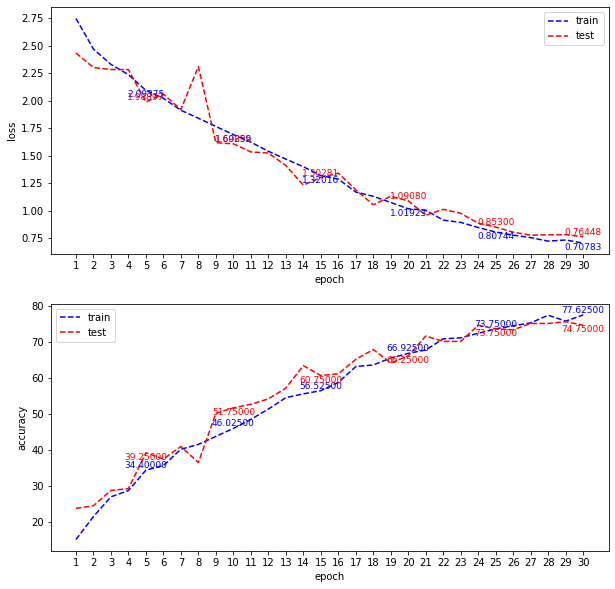

In [13]:
#visualize metric
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = [i for i in range(1, epochs+1)]

ax1.plot(x, train_loss_list, 'b--')
ax1.plot(x, test_loss_list, 'r--')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'])
ax1.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, train_loss_list[i], "{:0.5f}".format(train_loss_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='top')
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, test_loss_list[i], "{:0.5f}".format(test_loss_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='bottom')


ax2.plot(x, train_acc_list, 'b--')
ax2.plot(x, test_acc_list, 'r--')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'])
ax2.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, train_acc_list[i], "{:0.5f}".format(train_acc_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='bottom')
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, test_acc_list[i], "{:0.5f}".format(test_acc_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='top')

plt.show()